In [1]:
import numpy as np
import pandas as pd

In [2]:
!pwd

/Users/jamesreno/Documents/Documents - James’s MacBook Air/NYCDSA/Python/Python Project/Meetup_Data


In [3]:
rsvps = pd.read_csv('rsvps.csv')
meta_members = pd.read_csv('meta-members.csv')
meta_groups = pd.read_csv('meta-groups.csv')
meta_events = pd.read_csv('meta-events.csv')
m_to_g_edges = pd.read_csv('member-to-group-edges.csv')
member_edges = pd.read_csv('member-edges.csv')
group_edges = pd.read_csv('group-edges.csv')

# Data Organization
Below are the data sets retrieved from: https://www.kaggle.com/datasets/stkbailey/nashville-meetup?select=meta-groups.csv
on 04/19/2022

Defined their assumed definitions and links between data sets.

rsvps: (list of rsvps with member, event, and group)
has two indices - probably useless
event_id - unique id might be used to join to the meta_events
member_id - unique id might be used to join to: meta_members, m_to_g_edges, member_edges
group_id - unique id might be used to join to: meta_groups, m_to_g_edges, group_edges

meta_members: (list of members)
member_id - unique id might be used to join to m_to_g_edges, member_edges, rsvps
name - name of member
?hometown- either where they live or where they grew up
?city - where they joined meetup?
?state - where they are attending meetups?
lat - lattitude
lon - longitude

meta_groups: (list of groups)
group_id - unique id might be used to join to: rsvps, meta_events, m_to_g_edges, group_edges
group_name - group name
num_members - number of members
category_id - unique category id
category_name - broad category of the type of group
?organizer_id - member id of the organizer(s) or admin(s) ??? Need to confirm
group_urlname - url within the meetup.com space

meta_events: (list of events)
event_id - unique id might be used to join to: rsvps
group_id - unique id might be used to join to: rsvps, meta_groups, m_to_g_edges, group_edges
name - event name
time - Nashville time of event start time

m_to_g_edges: (member to group connections)
member_id - unique id might be used to join to: rsvps, meta_members, meta_events, member_edges
group_id - unique id might be used to join to: rsvps, meta_groups, meta_events, group_edges
weight - ?

member_edges: (data used to show connection between members)
member1 - unique member id
member2 - unique member id
weight - ?

group_edges: (data used to show connections between groups)
group1 - unique group id
group2 - unique group id
weight - ?

# Overall Approach Summary

The data in this data set were related to "Meetups" on Meetup.com based in Nashville, Tennessee.

The attributes of the data present were examined for completeness and type. Data types were adjusted as needed, such as string to Timestamp conversions. Unused index from CSV was removed.

A subset of the data were used for analysis to reduce variation due to extraneous factors. The subset included the last year of data included in the data set. This allowed for any seasonality to be included (i.e. if some groups are more active in one part of the year this wouldn't be accidentally overlooked). Any group with their earliest event date at or before the beginning of the calendar year of interest was included. This was done to eliminate any newly formed groups that may have skewed the data.

The day of the week most common to have an event was Saturday with Monday being the least common. It was noted that some groups were assigned to one category of group when clearly they could be associated with several categories.

Initially the number of events per category were assessed to identify which category type hosted the most events. A scatter plot was used to compare this to the number of members in the group associated with the event to determine if any specific relationship between the two existed. Overall it seemed as though a positive relationship did exist, however, there were outliers that highlighted some niche edge cases. Such as an investment group that had a high number of events but low members - this may be due to artificial suppression/hurdles to group membership (e.g. more selective process). Another was a social group that had a high number of members but only 1 event - this could be due to coincidence and perhaps the group admins abandoned the group during the time period examined.

In an attempt to more completely assess member engagement the total number of events attended per member during the time period of interest was assessed. The average number of events attended by each member by by group was collected and aggregated by category type. These data showed very different results than the number of members.

[Github](https://github.com/jamesreno2/python_project_eda)

[Presentation](https://docs.google.com/presentation/d/1aIWBDFWXKqkmtUZE00QX_gnn5vZlncO2tbszkXFW034/edit?usp=sharing)

In [29]:
rsvps.dtypes

Unnamed: 0     int64
event_id      object
member_id      int64
group_id       int64
dtype: object

In [31]:
len(rsvps['event_id'].unique())

19031

In [47]:
rsvps[rsvps[['event_id','member_id','group_id']].isna().all(axis=1)]

,Unnamed: 0,event_id,member_id,group_id


In [54]:
rsvps[rsvps['group_id'].isnull()]

,Unnamed: 0,event_id,member_id,group_id


## Removing Unwanted Index
The following function was used to remove the index imported from the csv files if it was present.

In [75]:
def drop_unnamed(df):
    #checking if 'Unnamed: 0' exists as a column name, if so drop and reassign
    
    if 'Unnamed: 0' in df.columns:
        return df.drop(labels='Unnamed: 0',axis=1)
    

In [76]:
rsvps=drop_unnamed(rsvps)
#rsvps.drop(labels='Unnamed: 0',axis=1)

In [79]:
for df in [rsvps,meta_members,meta_groups,meta_events,m_to_g_edges,member_edges,group_edges]:
    df = drop_unnamed(df)

In [80]:
meta_members.head()

,member_id,name,hometown,city,state,lat,lon
0,2069,Wesley Duffee-Braun,Brentwood,Brentwood,TN,36.00,-86.79
1,8386,Tim,Nashville,Nashville,TN,36.07,-86.78
2,9205,Brenda,Brentwood,Brentwood,TN,36.00,-86.79
3,17903,Steve,NaN,Nashville,TN,36.13,-86.80
4,20418,Andrea Reynolds,"Huntington, WV",Nashville,TN,36.17,-86.72


Data were examined for null/NaN values

In [83]:
meta_members.isna().sum()

member_id        0
name             0
hometown     19664
city             0
state           94
lat              0
lon              0
dtype: int64

In [87]:
len(meta_members['member_id'].unique())

24591

In [86]:
len(meta_members)

24591

In [109]:
meta_members.head()

,member_id,name,hometown,city,state,lat,lon
0,2069,Wesley Duffee-Braun,Brentwood,Brentwood,TN,36.00,-86.79
1,8386,Tim,Nashville,Nashville,TN,36.07,-86.78
2,9205,Brenda,Brentwood,Brentwood,TN,36.00,-86.79
3,17903,Steve,NaN,Nashville,TN,36.13,-86.80
4,20418,Andrea Reynolds,"Huntington, WV",Nashville,TN,36.17,-86.72


In [110]:
rsvps.loc[rsvps['member_id']==2069]

,event_id,member_id,group_id
14137,239307600,2069,18855476
26704,kjzzdlyvcbrb,2069,17872862
29418,234956674,2069,19277993
29611,rwnwplyvkblb,2069,19277993
29699,rwnwplyvhbrb,2069,19277993
32844,qxncmlywlbzb,2069,405938
32847,241937707,2069,405938
32856,qxncmlywkbtb,2069,405938
36071,qgllhkyvcbqb,2069,11862932
36077,qgllhkytqblb,2069,11862932


In [90]:
meta_events.head()

,event_id,group_id,name,time
0,243930425,26140018,2017 Nashville Walk to End Alzheimers - Octob...,2017-10-14 12:00:00
1,244208851,25604533,Steak Dinner on the Patio,2017-10-15 00:15:00
2,pxlktnywnbfb,25973656,Schedule Meetup,2017-10-03 23:30:00
3,244444551,18571126,"Happy Hour Wednesday, Jonathan's Green Hills, ...",2017-10-25 22:30:00
4,244257722,18571126,"Happy Hour Wednesday, Brentwood, Oct. 18",2017-10-18 22:30:00


## Event Date Data
Used Pandas Timestamp functionality to convert string date data to Timestamp
Extracted day of week data for analysis

In [ ]:
#import pandas as pd

#temp = pd.Timestamp('2020-11-25')
#print(temp.dayofweek, temp.day_name())

In [120]:
meta_events['time_ts']=meta_events['time'].apply(pd.Timestamp)
#meta_events['day_of_week']=meta_events['time_ts'].day_name()

In [121]:
meta_events.head()

,event_id,group_id,name,time,time_ts
0,243930425,26140018,2017 Nashville Walk to End Alzheimers - Octob...,2017-10-14 12:00:00,2017-10-14 12:00:00
1,244208851,25604533,Steak Dinner on the Patio,2017-10-15 00:15:00,2017-10-15 00:15:00
2,pxlktnywnbfb,25973656,Schedule Meetup,2017-10-03 23:30:00,2017-10-03 23:30:00
3,244444551,18571126,"Happy Hour Wednesday, Jonathan's Green Hills, ...",2017-10-25 22:30:00,2017-10-25 22:30:00
4,244257722,18571126,"Happy Hour Wednesday, Brentwood, Oct. 18",2017-10-18 22:30:00,2017-10-18 22:30:00


In [127]:
meta_events['day_of_week']=meta_events['time_ts'].apply(pd.Timestamp.day_name)

In [128]:
meta_events.head()

,event_id,group_id,name,time,time_ts,day_of_week
0,243930425,26140018,2017 Nashville Walk to End Alzheimers - Octob...,2017-10-14 12:00:00,2017-10-14 12:00:00,Saturday
1,244208851,25604533,Steak Dinner on the Patio,2017-10-15 00:15:00,2017-10-15 00:15:00,Sunday
2,pxlktnywnbfb,25973656,Schedule Meetup,2017-10-03 23:30:00,2017-10-03 23:30:00,Tuesday
3,244444551,18571126,"Happy Hour Wednesday, Jonathan's Green Hills, ...",2017-10-25 22:30:00,2017-10-25 22:30:00,Wednesday
4,244257722,18571126,"Happy Hour Wednesday, Brentwood, Oct. 18",2017-10-18 22:30:00,2017-10-18 22:30:00,Wednesday


In [129]:
print(min(meta_events['time_ts']))
print(max(meta_events['time_ts']))
print(max(meta_events['time_ts'])-min(meta_events['time_ts']))

2015-11-01 01:00:00
2017-10-30 23:15:00
729 days 22:15:00


In [130]:
729/365

1.9972602739726026

Initial exploration of the different attributes of the data and what values existed

In [131]:
meta_groups.head()

,group_id,group_name,num_members,category_id,category_name,organizer_id,group_urlname
0,339011,Nashville Hiking Meetup,15838,23,Outdoors & Adventure,4353803,nashville-hiking
1,19728145,Stepping Out Social Dance Meetup,1778,5,Dancing,118484462,steppingoutsocialdance
2,6335372,Nashville soccer,2869,32,Sports & Recreation,108448302,Nashville-soccer
3,10016242,NashJS,1975,34,Tech,8111102,nashjs
4,21174496,20's & 30's Women looking for girlfriends,2782,31,Socializing,184580248,new-friends-in-Nashville


In [132]:
meta_groups['category_name'].unique()

array(['Outdoors & Adventure', 'Dancing', 'Sports & Recreation', 'Tech',
       'Socializing', 'Religion & Beliefs', 'Singles', 'Writing', 'Games',
       'Career & Business', 'Pets & Animals', 'Music', 'Food & Drink',
       'LGBT', 'New Age & Spirituality', 'Movements & Politics',
       'Health & Wellbeing', 'Education & Learning',
       'Language & Ethnic Identity', 'Arts & Culture',
       'Cars & Motorcycles', 'Book Clubs', 'Photography',
       'Community & Environment', 'Hobbies & Crafts', 'Movies & Film',
       'Fitness', 'Support', 'Sci-Fi & Fantasy', 'Fashion & Beauty',
       'Parents & Family'], dtype=object)

In [134]:
meta_groups.groupby('category_name')['group_id'].size()

category_name
Arts & Culture                  9
Book Clubs                     11
Career & Business              93
Cars & Motorcycles              2
Community & Environment        20
Dancing                         5
Education & Learning           13
Fashion & Beauty                4
Fitness                        14
Food & Drink                   15
Games                          20
Health & Wellbeing             36
Hobbies & Crafts                6
LGBT                            6
Language & Ethnic Identity     13
Movements & Politics           12
Movies & Film                   6
Music                          19
New Age & Spirituality         33
Outdoors & Adventure           36
Parents & Family                7
Pets & Animals                  6
Photography                     5
Religion & Beliefs             18
Sci-Fi & Fantasy                4
Singles                         3
Socializing                    48
Sports & Recreation            26
Support                         9


In [283]:
#shows that the number of members isn't based on this data set

print(len(m_to_g_edges.loc[m_to_g_edges['group_id']==339011]['member_id'].unique()))
meta_groups.loc[meta_groups['group_id']==339011]

878


,group_id,group_name,num_members,category_id,category_name,organizer_id,group_urlname,avg_rsvps,first_event,num_events
0,339011,Nashville Hiking Meetup,15838,23,Outdoors & Adventure,4353803,nashville-hiking,10.462312,2017-06-14 14:00:00,200


In [ ]:
'''I was going to check if you had to be a member to attend an event, but I don't have specific membership data,
only member id and group id'''
#rsvps.loc[rsvps['group_id']==339011]['member_id'].unique().isin()

In [149]:
#count number of rsvps per event per group and get average number of attendees
test = rsvps.groupby(['group_id','event_id'])['member_id'].size().reset_index(name='counts')

In [161]:
meta_groups = meta_groups.drop(labels=['avg_rsvps'], axis = 1)

In [168]:
temp_gp = rsvps.groupby(['group_id','event_id'])['member_id'].size().groupby('group_id').agg('mean').reset_index(name='avg_rsvps')

In [171]:
temp_gp.loc[temp_gp['group_id']==26282355]

,group_id,avg_rsvps
598,26282355,1.333333


In [172]:
#complete meta_groups data set adding avg_rsvps
meta_groups=meta_groups.merge(temp_gp, how = 'left', on = 'group_id')

In [173]:
meta_groups.head()

,group_id,group_name,num_members,category_id,category_name,organizer_id,group_urlname,avg_rsvps
0,339011,Nashville Hiking Meetup,15838,23,Outdoors & Adventure,4353803,nashville-hiking,10.462312
1,19728145,Stepping Out Social Dance Meetup,1778,5,Dancing,118484462,steppingoutsocialdance,16.575000
2,6335372,Nashville soccer,2869,32,Sports & Recreation,108448302,Nashville-soccer,17.945000
3,10016242,NashJS,1975,34,Tech,8111102,nashjs,81.782609
4,21174496,20's & 30's Women looking for girlfriends,2782,31,Socializing,184580248,new-friends-in-Nashville,30.450000


In [176]:
#complete meta_groups data_set adding earliest event as proxy for group creation
meta_groups=meta_groups.merge(meta_events.groupby(['group_id'])['time_ts'].agg('min').reset_index(name='first_event'),how='left',on='group_id')

In [178]:
#complete meta_groups data set adding number of events total
meta_groups=meta_groups.merge(meta_events.groupby(['group_id'])['event_id'].size().reset_index(name='num_events'),how='left',on='group_id')

In [175]:
#sanity check to confirm number of events were counted correctly
meta_events.loc[meta_events['group_id']==26282355]

,event_id,group_id,name,time,time_ts,day_of_week
92,244479480,26282355,Moss Wright Park Meetup,2017-10-28 12:30:00,2017-10-28 12:30:00,Saturday
93,244293547,26282355,Moss Right Park,2017-10-21 13:00:00,2017-10-21 13:00:00,Saturday
94,244246979,26282355,Moss Right Park,2017-10-17 23:00:00,2017-10-17 23:00:00,Tuesday


In [156]:
test.loc[test['group_id']==26282355]

,group_id,event_id,counts
19024,26282355,244246979,2
19025,26282355,244293547,1
19026,26282355,244479480,1


In [179]:
#sanity check paired with above to confirm data were output correctly
meta_groups.loc[meta_groups['group_id']==26282355]

,group_id,group_name,num_members,category_id,category_name,organizer_id,group_urlname,avg_rsvps,first_event,num_events
330,26282355,Goodlettsville Roadrunners,11,9,Fitness,184360544,Goodlettsville-Roadrunners,1.333333,2017-10-17 23:00:00,3


In [225]:
#examining how many groups would remain if I subset the data to only include the last year
len(meta_groups.loc[meta_groups['first_event']<(max(meta_events['time_ts']).round('d')-pd.DateOffset(months=12))])

349

In [346]:
len(meta_events.loc[meta_events['time_ts']>=(max(meta_events['time_ts']).round('d')-pd.DateOffset(months=12))])

6634

In [145]:
#sanity checking that rsvps were counted correctly
rsvps.loc[(rsvps['group_id']==47094)&(rsvps['event_id']=='235958072')]

,event_id,member_id,group_id
102793,235958072,45253562,47094
102794,235958072,133931222,47094
102795,235958072,211623283,47094
102796,235958072,185299351,47094
102797,235958072,208234459,47094
102798,235958072,14040142,47094
102799,235958072,218342229,47094
102800,235958072,48664802,47094
102801,235958072,189365973,47094
102802,235958072,32832232,47094


In [184]:
#adding category name to events data
meta_events_t = meta_events.merge(meta_groups[['group_id','category_name']],how='left',on='group_id')

In [185]:
meta_events_t.head()

,event_id,group_id,name,time,time_ts,day_of_week,category_name
0,243930425,26140018,2017 Nashville Walk to End Alzheimers - Octob...,2017-10-14 12:00:00,2017-10-14 12:00:00,Saturday,Community & Environment
1,244208851,25604533,Steak Dinner on the Patio,2017-10-15 00:15:00,2017-10-15 00:15:00,Sunday,Pets & Animals
2,pxlktnywnbfb,25973656,Schedule Meetup,2017-10-03 23:30:00,2017-10-03 23:30:00,Tuesday,Support
3,244444551,18571126,"Happy Hour Wednesday, Jonathan's Green Hills, ...",2017-10-25 22:30:00,2017-10-25 22:30:00,Wednesday,Career & Business
4,244257722,18571126,"Happy Hour Wednesday, Brentwood, Oct. 18",2017-10-18 22:30:00,2017-10-18 22:30:00,Wednesday,Career & Business


In [181]:
%matplotlib inline
import seaborn as sns

<AxesSubplot:ylabel='Number of Events'>

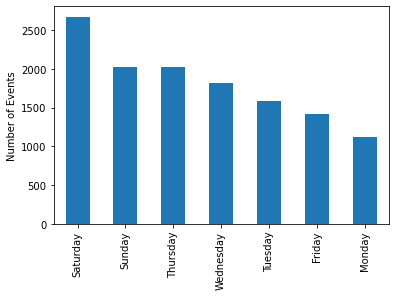

In [271]:
#displaying bar chart of the frequency of events on each day of the week

meta_events_t.loc[meta_events_t['time_ts']>=(max(meta_events_t['time_ts'])\
                                             .round('d')-pd.DateOffset(months=12))]['day_of_week']\
.value_counts().plot.bar(ylabel='Number of Events')

In [207]:
meta_events.plot.bar(ylab)

array(['Saturday', 'Sunday', 'Tuesday', 'Wednesday', 'Thursday', 'Monday',
       'Friday'], dtype=object)

<AxesSubplot:xlabel='Category', ylabel='Number of Events'>

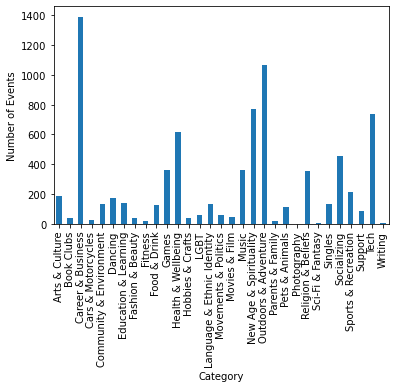

<AxesSubplot:ylabel='Number of Events'>

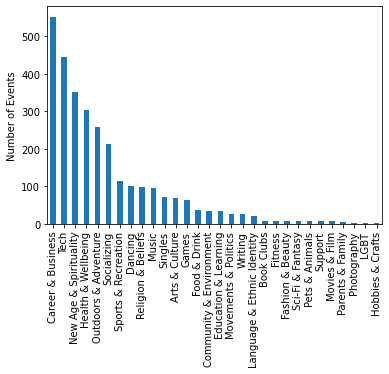

In [226]:
meta_events_t.loc[meta_events_t['day_of_week']=='Thursday']['category_name']\
.value_counts().plot(kind='bar', ylabel='Number of Events')

In [227]:
#subsetting the meta_groups data to be only those which had a first event of 1 year ago or earlier
meta_groups_i=meta_groups.loc[meta_groups['first_event']<(max(meta_events['time_ts']).round('d')-pd.DateOffset(months=12))]

In [228]:
meta_groups_i.head()

,group_id,group_name,num_members,category_id,category_name,organizer_id,group_urlname,avg_rsvps,first_event,num_events
1,19728145,Stepping Out Social Dance Meetup,1778,5,Dancing,118484462,steppingoutsocialdance,16.575000,2016-06-11 23:30:00,200
3,10016242,NashJS,1975,34,Tech,8111102,nashjs,81.782609,2015-11-12 00:00:00,23
5,11077852,Sunday Assembly Nashville,918,28,Religion & Beliefs,4765912,Sunday-Assembly-Nashville,15.410000,2015-11-14 23:00:00,200
7,1585196,Tennessee Hiking Group,4828,23,Outdoors & Adventure,13537265,TennesseeHikingGroup,7.180000,2016-06-22 23:30:00,200
10,18243826,Middle TN 40+ singles,2583,30,Singles,198309808,MTN-40,10.515152,2016-03-09 00:45:00,200


<AxesSubplot:ylabel='Number of Events'>

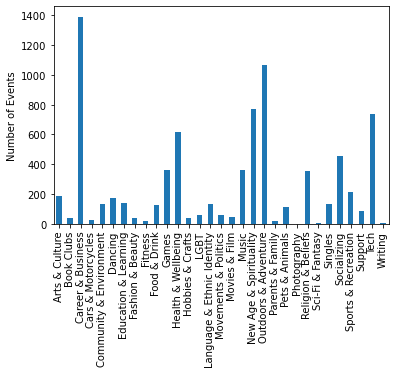

In [345]:
meta_groups_i.groupby('category_name')['num_events_target_period'].agg('sum')\
.plot(kind='bar', ylabel='Number of Events', xlabel='')

<AxesSubplot:ylabel='Mean Number of Events'>

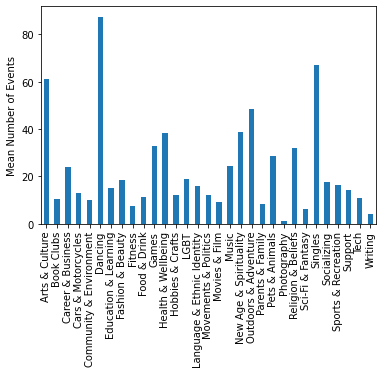

In [363]:
meta_groups_i.groupby('category_name')['num_events_target_period'].agg('mean')\
.plot(kind='bar', ylabel='Mean Number of Events', xlabel='')

In [230]:
#meta_groups_i (subset that included only groups which had a first event of 1 year before end of data set or 
#earlier) merged with meta_events_t (meta_events data with category name added) filtered here to only 
# include events during the last year of the data set
group_event_merged = meta_groups_i.merge(meta_events_t.loc\
                    [meta_events_t['time_ts']>=(max(meta_events['time_ts']).round('d')-pd.DateOffset(months=12))],
                                         \
                   how='left', on='group_id')

In [233]:
group_event_merged.shape

(7894, 16)

In [234]:
#adding number of events during target period (last 12 months of data set)
meta_groups_i = meta_groups_i.merge(group_event_merged.groupby('group_id')['event_id']\
                                    .size().reset_index(name='num_events_target_period'),how='left',on='group_id')

In [235]:
meta_groups_i.head()

,group_id,group_name,num_members,category_id,category_name,organizer_id,group_urlname,avg_rsvps,first_event,num_events,num_events_target_period
0,19728145,Stepping Out Social Dance Meetup,1778,5,Dancing,118484462,steppingoutsocialdance,16.575000,2016-06-11 23:30:00,200,139
1,10016242,NashJS,1975,34,Tech,8111102,nashjs,81.782609,2015-11-12 00:00:00,23,11
2,11077852,Sunday Assembly Nashville,918,28,Religion & Beliefs,4765912,Sunday-Assembly-Nashville,15.410000,2015-11-14 23:00:00,200,120
3,1585196,Tennessee Hiking Group,4828,23,Outdoors & Adventure,13537265,TennesseeHikingGroup,7.180000,2016-06-22 23:30:00,200,121
4,18243826,Middle TN 40+ singles,2583,30,Singles,198309808,MTN-40,10.515152,2016-03-09 00:45:00,200,126


In [304]:
#rerunning after num_events_target_period was added
#meta_groups_i (subset that included only groups which had a first event of 1 year before end of data set or 
#earlier) merged with meta_events_t (meta_events data with category name added) filtered here to only 
# include events during the last year of the data set
group_event_merged = meta_groups_i.merge(meta_events_t.loc\
                    [meta_events_t['time_ts']>=(max(meta_events['time_ts']).round('d')-pd.DateOffset(months=12))],\
                   how='left', on='group_id')

<AxesSubplot:xlabel='num_events_target_period', ylabel='num_members'>

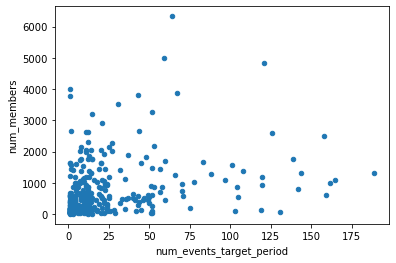

In [236]:
meta_groups_i.plot.scatter(x='num_events_target_period',y='num_members')

## Visualization of the relationship between Number of Events and Number of Members

This visualization allowed me to see which groups were successful (success = large number of members) and which were not and how that related to the number of events hosted during the target time period (last calendar year in the data).

In [354]:
import plotly

from plotly.graph_objs import Scatter, Figure, Layout
plotly.offline.init_notebook_mode(connected = True)


data = [Scatter(x = meta_groups_i['num_events_target_period'], y = meta_groups_i['num_members'], \
                mode = 'markers',text=(meta_groups_i['group_name']+', '+meta_groups_i['category_name'])\
                )]#, text=df['movie_title'])]
axistemplate = dict(showgrid=False,zeroline=False,title='Number of Events')
axistemplatey = dict(showgrid=False,zeroline=False,title='Number of Members')
layout = Layout(title = "Number of Events vs Membership",xaxis=axistemplate,yaxis=axistemplatey)
 
fig = Figure(data = data, layout = layout)

plotly.offline.iplot(fig, show_link = False)

In [ ]:
Scatter(stackgroup=)

In [300]:
import plotly.express as px

px.scatter(meta_groups_i, x="num_events_target_period", y="num_members", color="category_name",
                 title="Number of Events vs Number of Members")

In [301]:
#toyed with the idea of identifying the point of diminishing return
#fiteventstomembers2 = np.polyfit(x=meta_groups_i['num_events_target_period'],y=meta_groups_i['num_members'],deg=2)
#foffiteventstomembers2 = np.poly(fiteventstomembers2)

In [272]:
group_event_merged.head()

,group_id,group_name,num_members,category_id,category_name_x,organizer_id,group_urlname,avg_rsvps,first_event,num_events,event_id,name,time,time_ts,day_of_week,category_name_y
0,19728145,Stepping Out Social Dance Meetup,1778,5,Dancing,118484462,steppingoutsocialdance,16.575,2016-06-11 23:30:00,200,243960284,Line Dancing at Post 88. Information Only,2017-10-30 23:15:00,2017-10-30 23:15:00,Monday,Dancing
1,19728145,Stepping Out Social Dance Meetup,1778,5,Dancing,118484462,steppingoutsocialdance,16.575,2016-06-11 23:30:00,200,243113702,Halloween Party At Post 88. With Red Light 11,2017-10-29 00:00:00,2017-10-29 00:00:00,Sunday,Dancing
2,19728145,Stepping Out Social Dance Meetup,1778,5,Dancing,118484462,steppingoutsocialdance,16.575,2016-06-11 23:30:00,200,244318821,"Music, Dancing And Bar'q. Information Only.",2017-10-26 23:00:00,2017-10-26 23:00:00,Thursday,Dancing
3,19728145,Stepping Out Social Dance Meetup,1778,5,Dancing,118484462,steppingoutsocialdance,16.575,2016-06-11 23:30:00,200,243634634,Salsa dancing. Lesson And Dancing At Plaza Mar...,2017-10-22 01:00:00,2017-10-22 01:00:00,Sunday,Dancing
4,19728145,Stepping Out Social Dance Meetup,1778,5,Dancing,118484462,steppingoutsocialdance,16.575,2016-06-11 23:30:00,200,243306264,Friday night Dance Party At Preston . October ...,2017-10-21 00:00:00,2017-10-21 00:00:00,Saturday,Dancing


In [273]:
max(group_event_merged['time_ts'])-min(group_event_merged['time_ts'])

Timedelta('364 days 23:15:00')

identifying the subset of the RSVP data that relates to the groups during the period of interest.

RSVP subset below had fewer event IDs than the event data that was merged into group_event_merged.

Tracking down one of these instances showed to not be a data integrity issue or error in the handling of the data, but instead revealed that some events do not have records in the RSVP data set.

In [274]:
#measure of engagement - average percent of events attended per member
rsvp_subset = rsvps.loc[rsvps['event_id'].isin(group_event_merged['event_id'])]

In [275]:
'''checking to see if the number of events in each is the same. It isnt '''
len(group_event_merged['event_id'].unique())==len(rsvp_subset['event_id'].unique())

False

In [276]:
len(group_event_merged['event_id'].unique())

7854

In [277]:
len(rsvp_subset['event_id'].unique())

7745

In [278]:
rsvp_subset.head()

,event_id,member_id,group_id
4,244444551,1720391,18571126
5,244257722,1720391,18571126
6,243997614,1720391,18571126
7,243711748,1720391,18571126
8,243587675,1720391,18571126


In [289]:
meta_events.loc[(meta_events['group_id'].isin(\

group_event_merged.loc[~ group_event_merged['group_id'].isin(rsvp_subset['group_id'])]['group_id']))\
           
           & (meta_events['time_ts']>=(max(meta_events['time_ts']).round('d')-pd.DateOffset(months=12)))]

,event_id,group_id,name,time,time_ts,day_of_week
408,qrzvjgyvqbdc,8796112,NCFUG Monthly Meeting,2016-12-23 00:30:00,2016-12-23 00:30:00,Friday
409,qrzvjgyvpbgc,8796112,NCFUG Monthly Meeting,2016-11-25 00:30:00,2016-11-25 00:30:00,Friday


In [303]:
rsvps.loc[rsvps['group_id']==8796112]

,event_id,member_id,group_id
843,qrzvjgyvnbkc,135318882,8796112
844,qrzvjgyvhbjc,12480841,8796112
845,qrzvjgyvdbhc,9961811,8796112
846,qrzvjgyvdbhc,135318882,8796112


In [290]:
rsvp_subset.loc[rsvp_subset['group_id']==8796112]

,event_id,member_id,group_id


In [292]:
(max(meta_events['time_ts']).round('d')-pd.DateOffset(months=12))

Timestamp('2016-10-31 00:00:00')

In [293]:
max(meta_events['time_ts'])

Timestamp('2017-10-30 23:15:00')

In [349]:
group_event_merged.loc[group_event_merged['group_id']==8796112]

,group_id,group_name,num_members,category_id,category_name_x,organizer_id,group_urlname,avg_rsvps,first_event,num_events,num_events_target_period,event_id,name,time,time_ts,day_of_week,category_name_y
7380,8796112,Nashville ColdFusion User Group,41,34,Tech,12480841,Nashville-ColdFusion-User-Group,1.333333,2016-02-26 00:30:00,7,2,qrzvjgyvqbdc,NCFUG Monthly Meeting,2016-12-23 00:30:00,2016-12-23 00:30:00,Friday,Tech
7381,8796112,Nashville ColdFusion User Group,41,34,Tech,12480841,Nashville-ColdFusion-User-Group,1.333333,2016-02-26 00:30:00,7,2,qrzvjgyvpbgc,NCFUG Monthly Meeting,2016-11-25 00:30:00,2016-11-25 00:30:00,Friday,Tech


In [348]:
len(group_event_merged['event_id'].unique())

7854

In [351]:
len(rsvp_subset['member_id'].unique())

13460

Below I create a feature to measure group loyalty by measuring the percent of events each member attends within each group and then getting an average of those.
Newer members to engage with a group will drag the average down, so may need to consider percent since first engagement

In [305]:
m_to_g_edges.head()

,member_id,group_id,weight
0,2069,19277993,3
1,625050,19277993,2
2,1939496,19277993,1
3,2606806,19277993,4
4,3438546,19277993,1


In [314]:

rsvp_subset_aggregate= rsvp_subset_aggregate[['group_id', 'member_id']].merge(rsvp_subset.groupby(\
                                ['group_id','member_id'])['event_id']\
                               .size().reset_index(name='num_events_attended'), \
                                                                 how='left',left_on=['group_id','member_id'],\
                                                                right_on=['group_id','member_id'])

In [316]:
rsvp_subset_aggregate=rsvp_subset_aggregate.drop_duplicates()

In [317]:
rsvp_subset_aggregate.head()


,group_id,member_id,num_events_attended
0,18571126,1720391,15
5,18571126,194158019,2
6,18571126,186264694,1
18,18821254,125145522,3
21,20586888,1720391,11


In [321]:
meta_groups.head()

,group_id,group_name,num_members,category_id,category_name,organizer_id,group_urlname,avg_rsvps,first_event,num_events
0,339011,Nashville Hiking Meetup,15838,23,Outdoors & Adventure,4353803,nashville-hiking,10.462312,2017-06-14 14:00:00,200
1,19728145,Stepping Out Social Dance Meetup,1778,5,Dancing,118484462,steppingoutsocialdance,16.575000,2016-06-11 23:30:00,200
2,6335372,Nashville soccer,2869,32,Sports & Recreation,108448302,Nashville-soccer,17.945000,2017-02-23 00:00:00,200
3,10016242,NashJS,1975,34,Tech,8111102,nashjs,81.782609,2015-11-12 00:00:00,23
4,21174496,20's & 30's Women looking for girlfriends,2782,31,Socializing,184580248,new-friends-in-Nashville,30.450000,2016-12-04 01:00:00,40


In [323]:
rsvp_subset_aggregate = rsvp_subset_aggregate.merge(meta_groups[['group_id','category_name']], \
                                                    how='left', on='group_id')

<AxesSubplot:ylabel='Mean Number of Events Attended by Each Member'>

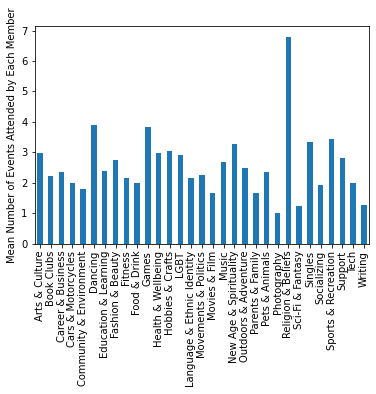

In [353]:
rsvp_subset_aggregate.groupby('category_name')['num_events_attended'].agg('mean').plot(kind='bar', ylabel='Mean Number of Events Attended by Each Member',xlabel='')

<AxesSubplot:ylabel='Total Number of RSVPs'>

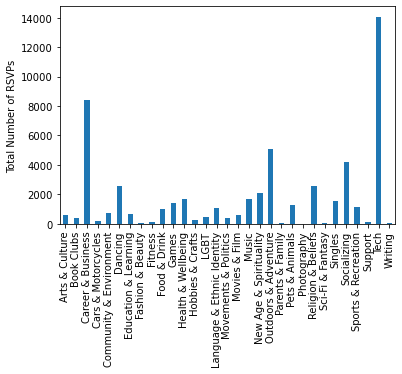

In [356]:
rsvp_subset_aggregate.groupby('category_name')['num_events_attended'].agg('sum').plot(kind='bar', ylabel='Total Number of RSVPs',xlabel='')

In [359]:
rsvp_subset_total=rsvp_subset_aggregate.merge(meta_groups[['group_id','group_name']],how='left',on='group_id')

rsvp_subset_total = rsvp_subset_total[['group_id','group_name','category_name']].merge(rsvp_subset_total\
            .groupby('group_id')['num_events_attended'].agg('sum').reset_index(name='total_rsvps'),\
            how='left',on='group_id')
rsvp_subset_total=rsvp_subset_total.drop_duplicates()

rsvp_subset_total=rsvp_subset_total.merge(meta_groups_i[['group_id','num_events_target_period']],how='left',\
                                          on='group_id')

In [360]:
data = [Scatter(x = rsvp_subset_total['num_events_target_period'], y = rsvp_subset_total['total_rsvps'], \
                mode = 'markers',text=(rsvp_subset_total['group_name']+', '+rsvp_subset_total['category_name'])\
                )]#, text=df['movie_title'])]
axistemplate = dict(showgrid=False,zeroline=False,title='Number of Events')
axistemplatey = dict(showgrid=False,zeroline=False,title='Number of RSVPs')
layout = Layout(title = "Number of Events vs RSVPs",xaxis=axistemplate,yaxis=axistemplatey)
 
fig = Figure(data = data, layout = layout)

plotly.offline.iplot(fig, show_link = False)

In [361]:
rsvp_subset_avg=rsvp_subset_aggregate.merge(meta_groups[['group_id','group_name']],how='left',on='group_id')

rsvp_subset_avg = rsvp_subset_avg[['group_id','group_name','category_name']].merge(rsvp_subset_avg\
            .groupby('group_id')['num_events_attended'].agg('mean').reset_index(name='mean_rsvps'),\
            how='left',on='group_id')
rsvp_subset_avg=rsvp_subset_avg.drop_duplicates()

rsvp_subset_avg=rsvp_subset_avg.merge(meta_groups_i[['group_id','num_events_target_period']],how='left',\
                                          on='group_id')

In [362]:
data = [Scatter(x = rsvp_subset_avg['num_events_target_period'], y = rsvp_subset_avg['mean_rsvps'], \
                mode = 'markers',text=(rsvp_subset_avg['group_name']+', '+rsvp_subset_avg['category_name'])\
                )]#, text=df['movie_title'])]
axistemplate = dict(showgrid=False,zeroline=False,title='Number of Events')
axistemplatey = dict(showgrid=False,zeroline=False,title='Mean Number of Events Attended')
layout = Layout(title = "Number of Events vs Mean Number Attended Per Member",xaxis=axistemplate,yaxis=axistemplatey)
 
fig = Figure(data = data, layout = layout)

plotly.offline.iplot(fig, show_link = False)

In [ ]:
#subsetting the data with event id to identify the number of events since member's first engagement
rsvp_subset_aggregate_adjusted = rsvp_subset.merge(rsvp_subset.groupby(\
                                ['group_id','member_id'])['event_id']\
                               .size().reset_index(name='num_events_attended'), \
                                                                 how='left',left_on=['group_id','member_id'],\
                                                                right_on=['group_id','member_id'])

In [328]:
rsvp_subset.head()

,event_id,member_id,group_id
4,244444551,1720391,18571126
5,244257722,1720391,18571126
6,243997614,1720391,18571126
7,243711748,1720391,18571126
8,243587675,1720391,18571126


In [338]:
#date of the first event attended per member/group combo and then the number of events that occurred since then
rsvp_subset_min_date_by_user = rsvp_subset[['member_id','group_id']].merge(rsvp_subset.merge(group_event_merged[['event_id','time_ts']], how='left',\
                  on='event_id').groupby(['member_id','group_id'])['time_ts'].agg('min')\
.reset_index(name='first_event_attended'),how='left',on=['member_id','group_id'])
                  

In [339]:
type(rsvp_subset_min_date_by_user)

pandas.core.frame.DataFrame

In [341]:
rsvp_subset_min_date_by_user=rsvp_subset_min_date_by_user.drop_duplicates()
rsvp_subset_min_date_by_user.head()

,member_id,group_id,first_event_attended
0,1720391,18571126,2017-02-16 19:00:00
5,194158019,18571126,2017-09-19 23:00:00
6,186264694,18571126,2017-09-24 18:00:00
18,125145522,18821254,2017-01-19 00:00:00
21,1720391,20586888,2017-05-17 23:30:00


In [342]:
#temporary helper dataframe with all necessary components to calculate number of events since first attendance
temp=rsvp_subset_min_date_by_user.merge(group_event_merged[['group_id','event_id','time_ts']],how='left',on='group_id')

In [343]:
temp.head()

,member_id,group_id,first_event_attended,event_id,time_ts
0,1720391,18571126,2017-02-16 19:00:00,244444551,2017-10-25 22:30:00
1,1720391,18571126,2017-02-16 19:00:00,244257722,2017-10-18 22:30:00
2,1720391,18571126,2017-02-16 19:00:00,243997614,2017-10-12 23:30:00
3,1720391,18571126,2017-02-16 19:00:00,243711748,2017-09-28 00:00:00
4,1720391,18571126,2017-02-16 19:00:00,243587675,2017-09-24 18:00:00


In [ ]:
#function to return the number of events possible for each 

In [ ]:
temp[['member_id','group_id']].merge(temp.loc[temp['time_ts']>=])